In [ ]:
#
#   ___                  _                
#  / _/______ ____  ____(_)__ _______     
# / _/ __/ _ `/ _ \/ __/ (_-</ __/ _ \    
#/_//_/  \_,_/_//_/\__/_/___/\__/\___/    
# ___ _____(_)__ ___ ____  / /_(_)       
# / _ `/ __/ (_-</ _ `/ _ \/ __/ /        
# \_, /_/ /_/___/\_,_/_//_/\__/_/         
#/___/
#
#Samee Lab @ Baylor College Of Medicine
#francisco.grisanticanozo@bcm.edu

In [1]:
import psutil
import platform
from datetime import datetime

print("="*40, "System Information", "="*40)
uname = platform.uname()
print(f"System: {uname.system}")
print(f"Node Name: {uname.node}")
print(f"Release: {uname.release}")
print(f"Version: {uname.version}")
print(f"Machine: {uname.machine}")

======================================== System Information ========================================
System: Darwin
Node Name: FranciscosMBP2.attlocal.net
Release: 19.6.0
Version: Darwin Kernel Version 19.6.0: Sun Jul  5 00:43:10 PDT 2020; root:xnu-6153.141.1~9/RELEASE_X86_64
Machine: x86_64


In [2]:
#Load libraries
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import sys
import pandas as pd
import warnings
import seaborn as sb
import sklearn
import tqdm
import scanpy as sc
import anndata
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.1 scipy==1.4.1 pandas==1.1.2 scikit-learn==0.23.2 statsmodels==0.12.0


In [4]:
sys.path.append('../')
from STANN.models import STANN
import STANN.utils as utils

In [3]:
import tensorflow as tf
import tensorflow.keras as keras
print(f'tensorflow=={tf.__version__} \nkeras=={tf.keras.__version__}')

tensorflow==2.2.0 
keras==2.3.0-tf


In [5]:
#Reproducibility
seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

In [6]:
################LOAD DATA###################

# check to see which data
print("[INFO] loading training data...")
adata_train = sc.read_h5ad("../data/scrna.h5ad")

print("[INFO] loading predict data...")
adata_predict = sc.read_h5ad("../data/seqfish.h5ad")

[INFO] loading training data...
[INFO] loading predict data...


In [7]:
model = STANN(act_fun='tanh',
              first_dense=160,
              second_dense=145.0,
              learning_rate=0.01,input_dim=adata_train.X.shape[1],
              output_dim=len(adata_train.obs.celltype.unique()))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 160)               1445120   
_________________________________________________________________
dense_1 (Dense)              (None, 145)               23345     
_________________________________________________________________
dense_2 (Dense)              (None, 15)                2190      
Total params: 1,470,655
Trainable params: 1,470,655
Non-trainable params: 0
_________________________________________________________________


In [9]:
X_train, Y_train, X_predict = utils.organize_data(adata_train=adata_train,
                                            adata_predict=adata_predict)

[INFO] Equal columns = True
[INFO] Data organized


In [10]:
X_train_scaled , scaler_train = utils.min_max(X=X_train)

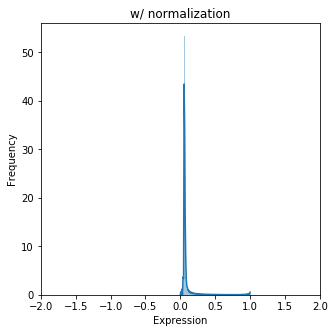

In [11]:
#Sample obs distribution
fig, ax = plt.subplots(figsize=(5,5))
sb.distplot(X_train_scaled.flatten(),bins=200,ax=ax)
ax.set_xlim(-2,2)
ax.set(xlabel='Expression', ylabel='Frequency')
ax.set_title('w/ normalization')
plt.show()

In [11]:
X_predict_scaled , scaler_predict = utils.min_max(X=X_predict)

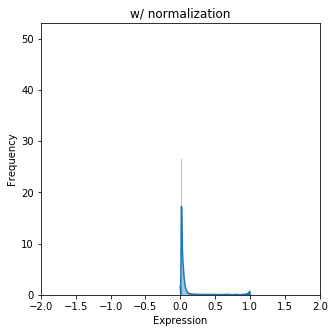

In [13]:
#Sample obs distribution
fig, ax = plt.subplots(figsize=(5,5))
sb.distplot(X_predict_scaled.flatten(),bins=200,ax=ax)
ax.set_xlim(-2,2)
ax.set(xlabel='Expression', ylabel='Frequency')
ax.set_title('w/ normalization')
plt.show()

In [12]:
Y_train_dummy,Y_train_ohe,encoder = utils.label_encoder(Y_train=Y_train)

In [13]:
x_train, x_test, y_train, y_test = utils.get_train_test_split(X_train_scaled,
                                                    Y_train_ohe,
                                                    test_size=0.10, 
                                                    random_state=40)

[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


In [14]:
class_weights = utils.get_class_weights(Y_train_ohe=y_train)
class_weights = {i : class_weights[i] for i in range(15)}
class_weights

array([0.64252979, 0.77287762, 5.84166667, 6.25892857, 0.69474727,
       6.31531532, 2.92083333, 2.93305439, 0.34481062, 0.82567727,
       4.70469799, 2.44250871, 1.31766917, 0.25743665, 6.20353982])

In [21]:
#early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='accuracy', 
                                      mode='min', 
                                      verbose=1,
                                      patience=30)

In [22]:
history = model.fit(x_train, 
                    y_train, 
                    validation_data=(x_test, y_test),
                    epochs=30,
                    class_weight=class_weights,
                    callbacks=[es])

Epoch 1/30
329/329 [==============================] - 1s 4ms/step - loss: 2.1365 - accuracy: 0.4156 - val_loss: 1.8201 - val_accuracy: 0.7100
Epoch 2/30
329/329 [==============================] - 1s 3ms/step - loss: 1.1036 - accuracy: 0.7982 - val_loss: 1.0831 - val_accuracy: 0.8246
Epoch 3/30
329/329 [==============================] - 1s 3ms/step - loss: 0.6224 - accuracy: 0.8709 - val_loss: 0.6871 - val_accuracy: 0.8785
Epoch 4/30
329/329 [==============================] - 1s 3ms/step - loss: 0.4057 - accuracy: 0.9179 - val_loss: 0.5949 - val_accuracy: 0.8358
Epoch 5/30
329/329 [==============================] - 1s 3ms/step - loss: 0.2886 - accuracy: 0.9386 - val_loss: 0.4274 - val_accuracy: 0.9247
Epoch 6/30
329/329 [==============================] - 1s 3ms/step - loss: 0.2160 - accuracy: 0.9556 - val_loss: 0.3414 - val_accuracy: 0.9410
Epoch 7/30
329/329 [==============================] - 1s 3ms/step - loss: 0.1691 - accuracy: 0.9630 - val_loss: 0.3043 - val_accuracy: 0.9299
Epoch 

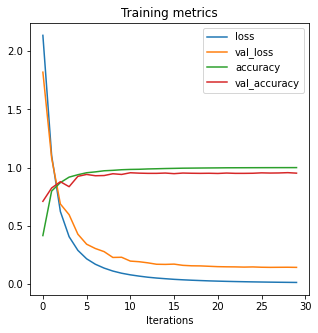

In [23]:
fig, axs = plt.subplots(figsize=(5,5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training metrics')
plt.xlabel('Iterations')
plt.legend()

In [24]:
utils.print_metrics(model=model,
                  x_train=x_train,
                  y_train=y_train,
                  x_test=x_test,
                  y_test=y_test)

[INFO] Accuracy -- Train: 1.000, Test: 0.952
[INFO] ROC -- Train: 1.000, Test: 0.998


In [34]:
predictions = utils.make_predictions(model=model,
                     X_predict=X_predict_scaled,
                     encoder=encoder,
                     adata_predict=adata_predict,
                     probabilities=False,
                     save=True
                    )
predictions

,X,Y,n_counts,log_counts,n_genes,mt_frac,FOV,STANN_predictions
barcode,,,,,,,,
0a,1766.40,283.42,1148.0,7.045776,717,0.0,0,Astro
1a,1891.40,348.38,841.0,6.734591,555,0.0,0,Neuron_GC
2a,1548.70,351.11,1704.0,7.440734,1066,0.0,0,Neuron_GC
3a,1657.60,357.37,1439.0,7.271704,940,0.0,0,OEC
4a,1767.40,392.22,1657.0,7.412764,1060,0.0,0,Neuron_GC
...,...,...,...,...,...,...,...,...
2045a,339.97,1532.30,853.0,6.748760,539,0.0,6,OEC
2046a,608.31,1544.70,735.0,6.599871,463,0.0,6,EC
2047a,779.11,1551.90,822.0,6.711740,543,0.0,6,OEC
